### Necessary Modules Installation

In [ ]:
%pip install qiskit qiskit-aer numpy matplotlib requests scipy
%pip install pylatexenc

# Task 4: Demonstrating Quantum Advantage

In [ ]:
"""
This task is intentionally open-ended, so no boilerplate code is provided.

You may use this notebook to develop your solution, or create a separate file if you prefer.
We recommend starting by copying over your previous implementations of the QRNG, TRNG, and PRNG.
Then, explore ways to modularize and combine these components to design a use case that
demonstrates the unique advantages of quantum randomness.

Your write-up can be included directly in this notebook or submitted separately.
You're welcome to prepare it as a Google Doc or LaTeX document and upload a PDF to the GitHub repository—
just be sure to clearly indicate where it can be found if it's not included here.
"""

### Necessary Imports

In [3]:
import numpy as np
import requests
import random
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import circuit_drawer, plot_circuit_layout
from scipy.special import erf
from collections import Counter
import hashlib
import json
from typing import Tuple, List, Dict, Any
import os
import secrets

### Important Constants

In [4]:
# Configuration
NUM_TRIALS = 5000
QRNG_API_URL = "https://qrng.idqloud.com/api/1.0"  # Replace with actual API
API_KEY = "aTo4BKRvnc49uRWDk034zaua87vGRXKk9TMLdfkI"
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
from collections import Counter

### Class For Getting QRNG Values

In [5]:
import requests
from typing import Union, List, Optional

QRNG_API_URL = "https://qrng.idqloud.com/api/1.0"
class QRNGaaS:
    def __init__(self, api_key: str):
        self.base_url = QRNG_API_URL
        self.headers = {
            "X-API-KEY": api_key,
            "Content-Type": "application/json"
        }
        self.max_batch_size = 32  # Actual API limit (32 for int, 64 for short)
        self.max_double_batch = 16

    def get_random_ints_batched(self, quantity: int) -> List[int]:
        """Get random 32-bit integers with batching to handle API limits"""
        batches = quantity // self.max_batch_size
        remainder = quantity % self.max_batch_size

        results = []
        for _ in range(batches):
            results.extend(self._get_batch(self.max_batch_size))

        if remainder > 0:
            results.extend(self._get_batch(remainder))

        return results

    def _get_batch(self, batch_size: int) -> List[int]:
        """Get a single batch of random integers"""
        params = {"quantity": batch_size}
        try:
            response = requests.get(
                f"{self.base_url}/int",
                headers=self.headers,
                params=params,
                timeout=10  # Add timeout to prevent hanging
            )
            response.raise_for_status()
            return response.json()["data"]
        except requests.exceptions.RequestException as e:
            print(f"API request failed: {e}")
            return []  # Return empty list on failure

    def _get_double_batch(self, batch_size: int, min_val: float, max_val: float) -> List[float]:
        params = {"min": min_val, "max": max_val, "quantity": batch_size}
        try:
            resp = requests.get(f"{self.base_url}/double", headers=self.headers, params=params, timeout=10)
            resp.raise_for_status()
            return resp.json()["data"]
        except requests.RequestException as e:
            print(f"Double batch request failed: {e}")
            return []

    def get_random_doubles_batched(
        self,
        quantity: int,
        min_val: float = 0.0,
        max_val: float = 1.0
    ) -> List[float]:
        """
        Retrieve 'quantity' true-random doubles in [min_val, max_val), batching to respect API limits.
        """
        full_batches = quantity // self.max_double_batch
        remainder = quantity % self.max_double_batch
        result: List[float] = []
        for _ in range(full_batches):
            result.extend(self._get_double_batch(self.max_double_batch, min_val, max_val))
        if remainder:
            result.extend(self._get_double_batch(remainder, min_val, max_val))
        return result




### Class For Generating JitterRNG (TRNG) Values

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import struct
from collections import deque
import time


class JitterRNG:
    def __init__(self, pool_size=256):
        self.entropy_pool = deque(maxlen=pool_size)
        self.pool_size = pool_size
        self.last_time = None

    def _collect_timing_jitter(self, iterations=1000):
        """Collect entropy from timing variations between CPU operations"""
        jitter_data = []

        self.last_time =  time.perf_counter_ns()
        #stores a high-resolution timestamp (in nanoseconds) in the self.last_time variable
        #used as the starting time to later compute the timing difference (or jitter) between two measurements

        for _ in range(iterations):
            """
            We need to introduce variability somehow.
            In the following space, do some arbitrary computation to introduce variability.
            We're not going to judge this part. Just make it reasonable so your notebook
            doesn't take forever to run.
            """
            # TODO: Do some arbitrary computation to introduce variability
            x = 0
            for i in range(69):
              x += (i*420)
            """

            """

            current_time = time.perf_counter_ns()  # TODO: Measure the time again
           # assert current_time != "CHANGE ME" # delete this when you're done


            time_diff = current_time - self.last_time # TODO: Calculate the jitter (timing difference)
            # hint: the JitterRNG class has a last_time attribute,
            # and you just computed the current time.
            #assert time_diff != "CHANGE ME" # delete this when you're done

            # Extract the least significant bits of the time difference
            # This is where the true randomness comes from
            lsb = time_diff & 255 # TODO: Get the lowest 8 bits of time_diff
            # hint: bitwise ops
            #assert lsb != "CHANGE ME" # delete this when you're done
            jitter_data.append(lsb)

            self.last_time = current_time # TODO: update self.last_time for next iteration
            #assert self.last_time != "CHANGE ME" # delete this when you're done

        return jitter_data

    def fill_entropy_pool(self):
        """Fill the entropy pool with timing jitter data"""
        # Collect enough jitter samples to fill the pool
        jitter_data = self._collect_timing_jitter(self.pool_size)

        # Add to the entropy pool
        for value in jitter_data:
            self.entropy_pool.append(value)

        return jitter_data

    def get_random_bytes(self, num_bytes=32):
        """Generate random bytes using the entropy pool"""
        # Make sure we have enough entropy
        if len(self.entropy_pool) < self.pool_size:
            self.fill_entropy_pool()

        # Mix the entropy pool using SHA-256
        pool_bytes = bytes(self.entropy_pool)
        mixed_entropy = hashlib.sha256(pool_bytes).digest()

        # Create an output buffer
        result = bytearray()

        # Generate requested number of bytes
        while len(result) < num_bytes:
            # Add more entropy to the pool
            self.fill_entropy_pool()

            # Mix new entropy with previous hash
            pool_bytes = bytes(self.entropy_pool)
            h = hashlib.sha256()
            h.update(mixed_entropy)
            h.update(pool_bytes)
            mixed_entropy = h.digest()

            # Add to result
            result.extend(mixed_entropy)

        # Return only the requested number of bytes
        return bytes(result[:num_bytes])

    def get_random_int(self, min_val=0, max_val=100):
        """Generate a random integer between min_val and max_val (inclusive)"""
        # Calculate how many bytes we need
        range_size = max_val - min_val + 1
        if range_size <= 0:
            raise ValueError("Invalid range")

        # Calculate how many bits we need
        bits_needed = range_size.bit_length()
        bytes_needed = (bits_needed + 7) // 8

        # Get random bytes
        random_bytes = self.get_random_bytes(bytes_needed)

        # Convert bytes to integer
        value = int.from_bytes(random_bytes, byteorder='big')

        # Map to our range
        return min_val + (value % range_size)

    def analyze_randomness(self, sample_size=1000):
        """Analyze the randomness of the generator"""
        # Generate samples
        samples = []
        for _ in range(sample_size):
            samples.append(self.get_random_int(0, 255))

        # Create plots
        plt.figure(figsize=(12, 10))

        # Plot 1: Distribution histogram
        plt.subplot(2, 2, 1)
        plt.hist(samples, bins=32, color='blue', alpha=0.7)
        plt.title('Distribution of Random Values')
        plt.xlabel('Value')
        plt.ylabel('Frequency')

        # Plot 2: Sequential values
        plt.subplot(2, 2, 2)
        plt.plot(samples[:100], '.-', alpha=0.7)
        plt.title('First 100 Generated Values')
        plt.xlabel('Sample Index')
        plt.ylabel('Value')

        # Plot 3: Scatter plot of consecutive values
        plt.subplot(2, 2, 3)
        plt.scatter(samples[:-1], samples[1:], alpha=0.5, s=5)
        plt.title('Scatter Plot of Consecutive Values')
        plt.xlabel('Value n')
        plt.ylabel('Value n+1')

        # Plot 4: Autocorrelation
        plt.subplot(2, 2, 4)
        autocorr = np.correlate(samples, samples, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        plt.plot(autocorr[:50])
        plt.title('Autocorrelation')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')

        plt.tight_layout()
        plt.show()

        return samples

### Class for LCG PRNG Numbers

In [7]:
class SecurePRNG:
    def __init__(self):
        pass  # No need for seed — uses OS randomness

    def next_bit(self):
        return secrets.randbits(1)

    def next_int(self, min_value=0, max_value=2**32 - 1):
        return secrets.randbelow(max_value - min_value + 1) + min_value

    def next_float(self):
        return secrets.randbits(53) / (1 << 53)  # Uniform in [0, 1)

### Class for RNG

In [8]:
class RNGProviders:
    @staticmethod
    def qrng(size: int = 1) -> List[int]:
        """Quantum RNG from IDQuantique's service (simulated)"""
        qrng = QRNGaaS(API_KEY)
        ints = qrng.get_random_ints_batched(quantity=size)
        return ints

    @staticmethod
    def trng(size: int = 1) -> List[int]:
        """System TRNG (uses system entropy)"""
        mic_trng = JitterRNG()
        ints = []
        for _ in range(size):
            ints.append(mic_trng.get_random_int(-2147483648, 2147483647))
        return ints

    @staticmethod
    def prng(size: int = 1) -> List[int]:
        """PRNG from OS"""
        output = []
        prng = SecurePRNG()
        for _ in range(size):
          output.append(prng.next_int())
        return output

### Class for Bell Test Simulation implemented using Qiskit and AerSimulator

In [9]:
class BellTest:
    def __init__(self, rng_provider: callable):
        self.rng = rng_provider
        self.results: List[Tuple[int, int, int, int]] = []
        self.simulator = AerSimulator()
        self.rng_bits: List[int] = []

    def run_experiment(self, num_trials: int) -> None:
      for _ in range(num_trials):
          try:
              a_basis = self.rng(1)[0] % 2
              b_basis = self.rng(1)[0] % 2
              self.rng_bits.extend([a_basis, b_basis])  # Store bits
          except Exception as e:
              print(f"Error getting random numbers: {e}")
              a_basis, b_basis = 0, 0
              self.rng_bits.extend([0, 0])  # Store fallback bits

          qc = self._create_bell_circuit(a_basis, b_basis)
          result = self.simulator.run(qc, shots=1).result()
          counts = result.get_counts(qc)
          outcome = list(counts.keys())[0]

          a_result = int(outcome[0])
          b_result = int(outcome[1])

          self.results.append((a_basis, b_basis, a_result, b_result))

    def get_rng_bits(self) -> str:
        """Return raw RNG bits used for basis selection as a binary string"""
        return ''.join(str(bit) for bit in self.rng_bits)

    def _create_bell_circuit(self, a_basis: int, b_basis: int) -> QuantumCircuit:
      if a_basis not in [0, 1] or b_basis not in [0, 1]:
          raise ValueError("Measurement bases must be 0 or 1")
      qc = QuantumCircuit(2, 2)
      qc.h(0)
      qc.cx(0, 1)
      if a_basis:
          qc.h(0)
      if b_basis:
          qc.h(1)
      qc.measure([0, 1], [0, 1])
      return qc

    def calculate_chsh(self) -> float:
        """Calculate the CHSH inequality value S"""
        correlations = {
            (0, 0): 0, (0, 1): 0,
            (1, 0): 0, (1, 1): 0
        }
        counts = {
            (0, 0): 0, (0, 1): 0,
            (1, 0): 0, (1, 1): 0
        }

        for a_basis, b_basis, a_result, b_result in self.results:
            # Convert to ±1
            a_val = 1 if a_result == 0 else -1
            b_val = 1 if b_result == 0 else -1

            correlations[(a_basis, b_basis)] += a_val * b_val
            counts[(a_basis, b_basis)] += 1

        # Calculate expectation values
        E = {}
        for basis in correlations:
            if counts[basis] > 0:
                E[basis] = correlations[basis] / counts[basis]
            else:
                E[basis] = 0

        # CHSH value
        S = E[(0, 0)] - E[(0, 1)] + E[(1, 0)] + E[(1, 1)]
        return S

    def run_statistical_tests(self) -> Dict[str, Any]:
        """Run battery of statistical tests on the RNG outputs"""
        # Extract all measurement choices
        choices = [a_basis for a_basis, _, _, _ in self.results] + \
                  [b_basis for _, b_basis, _, _ in self.results]

        # Test uniformity
        freq = Counter(choices)
        total = len(choices)
        obs = [freq[0], freq[1]]
        exp = [total/2, total/2]
        chi2, p_value = chisquare(f_obs=obs, f_exp=exp)

        # Calculate Shannon entropy
        entropy = -sum((count/total) * np.log2(count/total)
                  for count in freq.values() if count > 0)

        # Autocorrelation test
        shifted = choices[1:] + [choices[0]]
        matches = sum(1 for a, b in zip(choices, shifted) if a == b)
        autocorr = matches / len(choices)

        # Run additional tests (simplified versions)
        runs_test = self._perform_runs_test(choices)
        spectral_test = self._perform_spectral_test(choices)

        return {
            'chi_squared': (chi2, p_value),
            'shannon_entropy': entropy,
            'autocorrelation': autocorr,
            'runs_test': runs_test,
            'spectral_test': spectral_test,
            'ideal_entropy': 1.0,
            'ideal_autocorr': 0.5
        }

    def _perform_runs_test(self, sequence: List[int]) -> Dict[str, float]:
        """Simplified runs test for randomness"""
        runs = 1
        for i in range(1, len(sequence)):
            if sequence[i] != sequence[i-1]:
                runs += 1

        n = len(sequence)
        expected_runs = (2 * n - 1) / 3
        std_dev = np.sqrt((16 * n - 29) / 90)
        z_score = (runs - expected_runs) / std_dev

        return {
            'runs': runs,
            'expected': expected_runs,
            'z_score': z_score,
            'p_value': 2 * (1 - self._normal_cdf(abs(z_score)))
        }

    def _perform_spectral_test(self, sequence: List[int]) -> Dict[str, float]:
        """Simplified spectral test for randomness"""
        # Convert to ±1
        s = np.array([1 if x else -1 for x in sequence])
        n = len(s)

        # Discrete Fourier Transform
        fft = np.fft.fft(s)
        magnitudes = np.abs(fft)[1:n//2]  # Ignore DC component and symmetric part

        # Compute normalized peak height
        peak_height = np.max(magnitudes) / np.sqrt(n * np.log(n))

        return {
            'peak_height': peak_height,
            'threshold': np.sqrt(2.9957326),  # 99% confidence level
            'passed': peak_height < np.sqrt(2.9957326)
        }

    def show_circuit(self, a_basis: int, b_basis: int) -> None:
        """Display the Bell circuit with specified measurement bases"""
        qc = self._create_bell_circuit(a_basis, b_basis)
        qc.draw(output="mpl")  # This uses matplotlib to draw
        plt.show()

    @staticmethod
    def _normal_cdf(x: float) -> float:
        """Approximation of standard normal CDF"""
        return (1.0 + erf(x / np.sqrt(2.0))) / 2.0

### Method for Running Bell Test using Different RNG Values

In [10]:
def compare_rng_methods() -> Dict[str, Dict[str, Any]]:
    methods = {
        'QRNG': RNGProviders.qrng,
        'TRNG': RNGProviders.trng,
        'PRNG': RNGProviders.prng
    }


    results = {}

    for name, provider in methods.items():
        print(f"\nRunning {name}...")
        test = BellTest(provider)
        test.run_experiment(NUM_TRIALS)

        # Get the bit sequence from the BellTest instance
        input_bits = test.get_rng_bits()  # Make sure this returns a string like '010110...'

        chsh_value = test.calculate_chsh()
        stats = test.run_statistical_tests()

        results[name] = {
            'CHSH': chsh_value,
            'stats': stats,
            'violation': chsh_value > 2  # Classical bound
        }

        print(f"{name} Results:")
        print(f"  CHSH Value: {chsh_value:.4f}")
        print(f"  Violation: {'Yes' if chsh_value > 2 else 'No'}")
        print(f"  Shannon Entropy: {stats['shannon_entropy']:.4f} (Ideal: 1.0)")
        print(f"  Autocorrelation: {stats['autocorrelation']:.4f} (Ideal: 0.5)")
        print(f"  Chi-squared p-value: {stats['chi_squared'][1]:.4f}")
        print(f"  Runs Test z-score: {stats['runs_test']['z_score']:.4f}")
        print(f"  Spectral Test passed: {stats['spectral_test']['passed']}")

    return results

### Method for Visualizing all Results

In [11]:
def visualize_results(results: Dict[str, Dict[str, Any]]) -> None:
    names = list(results.keys())
    chsh_values = [results[name]['CHSH'] for name in names]
    violations = [results[name]['violation'] for name in names]

    plt.figure(figsize=(12, 6))

    # CHSH values plot
    plt.subplot(1, 2, 1)
    bars = plt.bar(names, chsh_values, color=['#1f77b4', '#2ca02c', '#d62728'])
    plt.axhline(y=2, color='black', linestyle='--', label='Classical Bound')
    plt.axhline(y=2*np.sqrt(2), color='purple', linestyle=':', label='Quantum Bound')
    plt.ylabel('CHSH Value')
    plt.title('CHSH Inequality Test Results')
    plt.legend()

    # Statistical tests plot
    plt.subplot(1, 2, 2)
    entropy = [results[name]['stats']['shannon_entropy'] for name in names]
    autocorr = [results[name]['stats']['autocorrelation'] for name in names]

    x = np.arange(len(names))
    width = 0.35

    plt.bar(x - width/2, entropy, width, label='Entropy (ideal=1.0)')
    plt.bar(x + width/2, autocorr, width, label='Autocorr (ideal=0.5)')
    plt.xticks(x, names)
    plt.title('Statistical Test Results')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Final Implementation of all classes for simulating circuit

In [ ]:
if __name__ == "__main__":
    # Run the comparison

    results = compare_rng_methods()
    visualize_results(results)

    bell_test = BellTest(RNGProviders.qrng)
    bell_test.show_circuit(a_basis=0, b_basis=1)

    # Print detailed results
    print("\nDetailed Results:")
    for name, data in results.items():
        print(f"\n{name}:")
        print(f"  CHSH Value: {data['CHSH']:.4f}")
        print(f"  Violation of Classical Bound: {data['violation']}")
        print("  Statistical Tests:")
        for test, value in data['stats'].items():
            if test not in ['ideal_entropy', 'ideal_autocorr']:
                print(f"    {test}: {value}")

### Simulated data taken from colab due to less computation power, this data was computed using 5000 samples of each QRNG, TRNG and PRNG

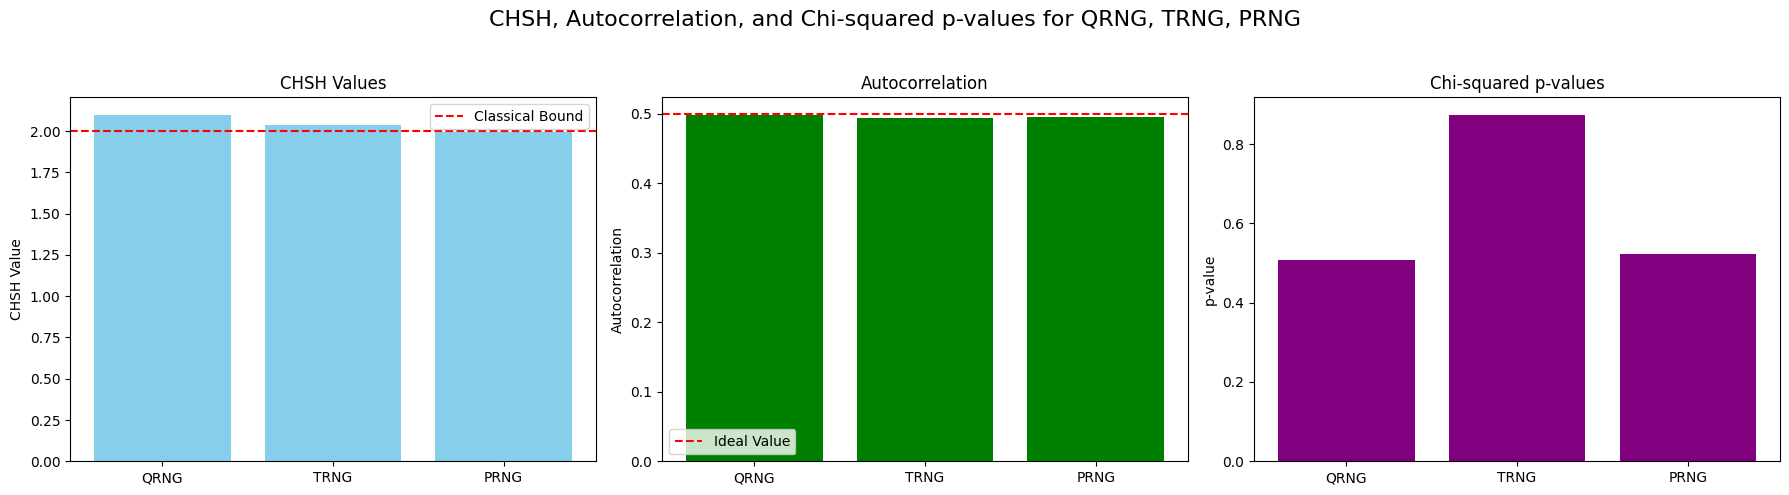

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data for QRNG, TRNG, and PRNG
generators = ['QRNG', 'TRNG', 'PRNG']

chsh_values = [2.0997, 2.0343, 1.9925]
shannon_entropy = [0.9999, 1.0000, 1.0000]
autocorrelation = [0.4985, 0.4935, 0.4946]
chi_squared_p = [0.5066, 0.8744, 0.5222]
runs_test_z = [-24.7306, -23.9804, -38.2196]
spectral_passed = [True, True, True]

# Set up the figure with a single row of 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('CHSH, Autocorrelation, and Chi-squared p-values for QRNG, TRNG, PRNG', fontsize=16)

# Plot CHSH Values
axs[0].bar(generators, chsh_values, color='skyblue')
axs[0].axhline(y=2.0, color='r', linestyle='--', label='Classical Bound')
axs[0].set_title('CHSH Values')
axs[0].set_ylabel('CHSH Value')
axs[0].legend()

# Plot Autocorrelation
axs[1].bar(generators, autocorrelation, color='green')
axs[1].axhline(y=0.5, color='r', linestyle='--', label='Ideal Value')
axs[1].set_title('Autocorrelation')
axs[1].set_ylabel('Autocorrelation')
axs[1].legend()

# Plot Chi-squared p-values
axs[2].bar(generators, chi_squared_p, color='purple')
axs[2].set_title('Chi-squared p-values')
axs[2].set_ylabel('p-value')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Code to show circuit

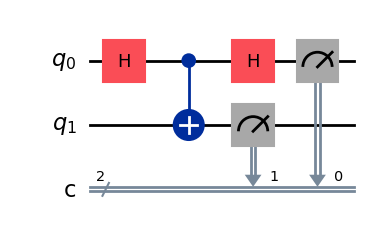

In [6]:
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer
from IPython.display import display

def _create_bell_circuit(a_basis: int, b_basis: int) -> QuantumCircuit:
    if a_basis not in [0, 1] or b_basis not in [0, 1]:
        raise ValueError("Measurement bases must be 0 or 1")
    
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    if a_basis:
        qc.h(0)
    if b_basis:
        qc.h(1)
    qc.measure([0, 1], [0, 1])
    return qc

# Create the circuit
circuit = _create_bell_circuit(1, 0)

# Display the circuit diagram
circuit.draw('mpl')  # Use 'mpl' for matplotlib-based visualization
